In [51]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from numba import jit
from scipy import integrate, interpolate

%load_ext line_profiler

import camb, os
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

from astropy import units as u
from astropy import constants as const


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Using CAMB 0.1.6.1 installed at /Users/fbianchini/.local/lib/python2.7/site-packages/camb


In [4]:
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [7]:
results = camb.get_results(pars)
bkd = camb.get_background(pars)

In [21]:
kmax  = 100.
zstar = bkd.get_derived_params()['zstar']


In [22]:
PK_nl = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax, zmax=zstar)
PK_lin = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax, zmax=zstar)


In [210]:
# Constants n stuff
km2Mpc     = (u.km).to(u.Mpc)
Mpc2m      = (u.Mpc).to(u.m)
G          = const.G.value # m^3/kg s^2
mu_e       = 1.14
m_p        = const.m_p.value # kg
sigma_T    = const.sigma_T.value # m^2
T0_square  = 7.425625e12 # muK^2
#rho_c0     = crit_rho(0.,**cosmo) # kg/m^3
rho_c0     = 3.*(bkd.hubble_parameter(0.)*km2Mpc)**2/(8.*np.pi*G)
const_ksz  = sigma_T * rho_c0 * pars.omegab / (mu_e * m_p) # m^-1
gamma      = 0.55
N_He       = 0. # N_He = 0, 1, 2 => Neutral, Single, Fully Ionized Helium
Chi        = (1.-pars.YHe*(1-N_He/4.))/(1.-pars.YHe/2.)
const_new  = const_ksz**2 * Chi**2 / const.c.value * 8. * np.pi**2



In [292]:
#=========================================================
#================ Nasty Functions ========================
#=========================================================

def nasty_integral_lcdm_lin(mu, kprime, k, z): # Mpc^6
#     print mu, kprime, k, z
#     print 1./(2.*np.pi)**2 * PK_lin(z,np.sqrt(abs(k**2+kprime**2-2*mu*k*kprime))) * PK_lin(z,kprime) * (((k/kprime)**2-2.*mu*(k/kprime))*(1.-mu**2))/(1.+(k/kprime)**2-2.*mu*(k/kprime))
    return 1./(2.*np.pi)**2 * PK_lin.P(z,np.sqrt(abs(k**2+kprime**2-2*mu*k*kprime))) * PK_lin.P(z,kprime) * (((k/kprime)**2-2.*mu*(k/kprime))*(1.-mu**2))/(1.+(k/kprime)**2-2.*mu*(k/kprime))

def nasty_integral_lcdm_halo(mu, kprime, k, z):# Mpc^6
    return 1./(2.*np.pi)**2 * PK_nl.P(z,np.sqrt(abs(k**2+kprime**2-2*mu*k*kprime))) * PK_lin.P(z,kprime) * (((k/kprime)**2-2.*mu*(k/kprime))*(1.-mu**2))/(1.+(k/kprime)**2-2.*mu*(k/kprime))

#=========================================================
#========= Nasty Functions Integrated ====================
#=========================================================

# @jit
def nasty_integral_integrated_lcdm_lin(k,z): # [Mpc/h]**5
    mus    = np.linspace(-1.,1,50)
    kappas = np.logspace(-3,2,50)

    integrand_k = np.empty(len(kappas))
    for idxk, kappa in enumerate(kappas):
        integrand_k_mu = np.empty(len(mus))
        for idxmu, mu in enumerate(mus):
            integrand_k_mu[idxmu] = nasty_integral_lcdm_lin(mu, kappa, k, z)
        integrand_k[idxk] = integrate.simps(integrand_k_mu, x=mus)
    return integrate.simps(np.nan_to_num(integrand_k), x=kappas)
            
def nasty_integral_integrated_lcdm_halo(k,z): # [Mpc/h]**5
    mus    = np.linspace(-1.,1,50)
    kappas = np.logspace(-3,2,50)

    integrand_k = np.empty(len(kappas))
    for idxk, kappa in enumerate(kappas):
        integrand_k_mu = np.empty(len(mus))
        for idxmu, mu in enumerate(mus):
            integrand_k_mu[idxmu] = nasty_integral_lcdm_halo(mu, kappa, k, z)
        integrand_k[idxk] = integrate.simps(integrand_k_mu, x=mus)

    return integrate.simps(np.nan_to_num(integrand_k), x=kappas)

#==========================================================
#================ Delta Functions =========================
#==========================================================

@np.vectorize
def delta_b_2_lcdm_lin(k,z): # [Mpc/s h]**2
#     print k**3/(2.*np.pi**2), ((bkd.hubble_parameter(z)*km2Mpc)/(1.+z))**2, growth(z)**2,  nasty_integral_integrated_lcdm_lin(k,z)
    return k**3/(2.*np.pi**2) * ((bkd.hubble_parameter(z)*km2Mpc)/(1.+z))**2 * growth(z)**2 * nasty_integral_integrated_lcdm_lin(k,z)
@np.vectorize
def delta_b_2_lcdm_halo(k,z): # [Mpc/s h]**2
    return k**3/(2.*np.pi**2) * ((bkd.hubble_parameter(z,)*km2Mpc)/(1.+z))**2 * growth(z)**2 * nasty_integral_integrated_lcdm_halo(k,z)

#=========================================================
#================ kSZ Functions ==========================
#=========================================================

@np.vectorize
def ksz_integrand_lcdm_lin(z,ell): # [Mpc/s h]**2 * Mpc * s Mpc/km = Mpc^3/ s h^2 => [m^3/s h^2]!!!!
    return (1+z)**4 * np.exp(-2.*opt_depth(z, Chi)) * bkd.comoving_radial_distance(z)/(bkd.hubble_parameter(z)*km2Mpc) * delta_b_2_lcdm_lin(ell/(bkd.comoving_radial_distance(z)),z) * (Mpc2m)**3 #/(.01*cosmo['H0'])**2

@np.vectorize
def ksz_integrand_lcdm_halo(z,ell): # [Mpc/s h]**2 * Mpc * s Mpc/km = Mpc^3/ s h^2 => [m^3/s h^2]!!!!
    return (1+z)**4 * np.exp(-2.*opt_depth(z,Chi)) * bkd.comoving_radial_distance(z)/(bkd.hubble_parameter(z)*km2Mpc) * delta_b_2_lcdm_halo(ell/(bkd.comoving_radial_distance(z)),z) * (Mpc2m)**3 #/(.01*cosmo['H0'])**2

#=========================================================
#================ Cosmo Functions ========================
#=========================================================

def opt_depth(z, Chi): # unitless
    const_tau = const_ksz * Chi * const.c.value # s^-1
    integrand_opt_depth = lambda x: (1.+x)**2/(bkd.hubble_parameter(z)*km2Mpc)
    return integrate.quad(integrand_opt_depth,0.,z)[0] * const_tau

def growth(z, omega_m=pars.omegab+pars.omegac, gamma=0.55): # a' la Linder, unitless
    return omega_m**gamma * ((1.+z)**3 / ( (bkd.hubble_parameter(z)/ pars.H0)**2) )**gamma

In [299]:
#Do integral over z
zmax   = 10.
zs     = np.linspace(1e-5,zmax,50)
dzs    = (zs[2:]-zs[:-2])/2
zs     = zs[1:-1]
ls     = np.array([100,500,1000,2000,3000,4000,5000,10000])#np.arange(2,2500+1, dtype=np.float64)
cl_ksz_lin = np.zeros(ls.shape)
cl_ksz_nl  = np.zeros(ls.shape)
w      = np.ones(zs.shape) #this is just used to set to zero k values out of range of interpolation

for i, l in enumerate(ls):
    k = l/(bkd.comoving_radial_distance(zs))
    w[:] = 1
    w[k<1e-4] = 0
    w[k>=kmax] = 0
    cl_ksz_lin[i] = np.dot(dzs, ksz_integrand_lcdm_lin(zs,l))
    cl_ksz_nl[i]  = np.dot(dzs, ksz_integrand_lcdm_halo(zs,l))


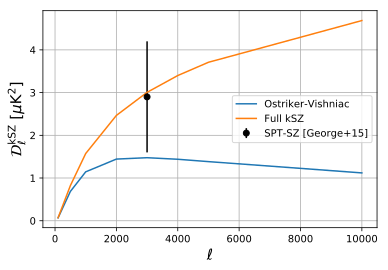

In [316]:
plt.plot(ls, T0_square * const_new * ls*(ls+1.)/(2.*ls+1.)**3 * cl_ksz_lin / (2*np.pi), label=r'Ostriker-Vishniac')
plt.plot(ls, T0_square * const_new * ls*(ls+1.)/(2.*ls+1.)**3 * cl_ksz_nl / (2*np.pi), label=r'Full kSZ')
plt.errorbar(3000, 2.9, 1.3, c='k', fmt='o', label='SPT-SZ [George+15]')
plt.grid()
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$\mathcal{D}_{\ell}^{\rm kSZ}$ [$\mu$K$^2$]', size=15)
plt.legend(loc='center right')
plt.savefig('/Users/fbianchini/Desktop/cl_ksz.pdf')